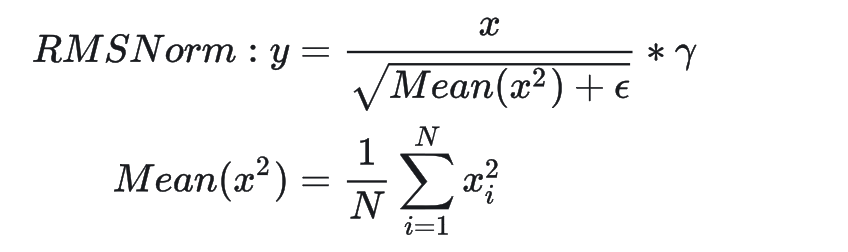

In [3]:
import torch
import torch.nn as nn
class RMSNorm(torch.nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps # ε
        self.weight = nn.Parameter(torch.ones(dim)) #可学习参数γ

    def _norm(self, x):
        # RMSNorm
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        return output * self.weight

we want to get Relative position of  K,Q

f is the absolute position , after attention inner product g , we can get the relative position by (m-n)

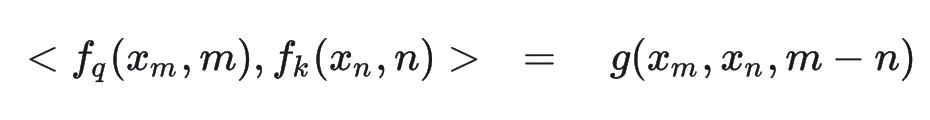

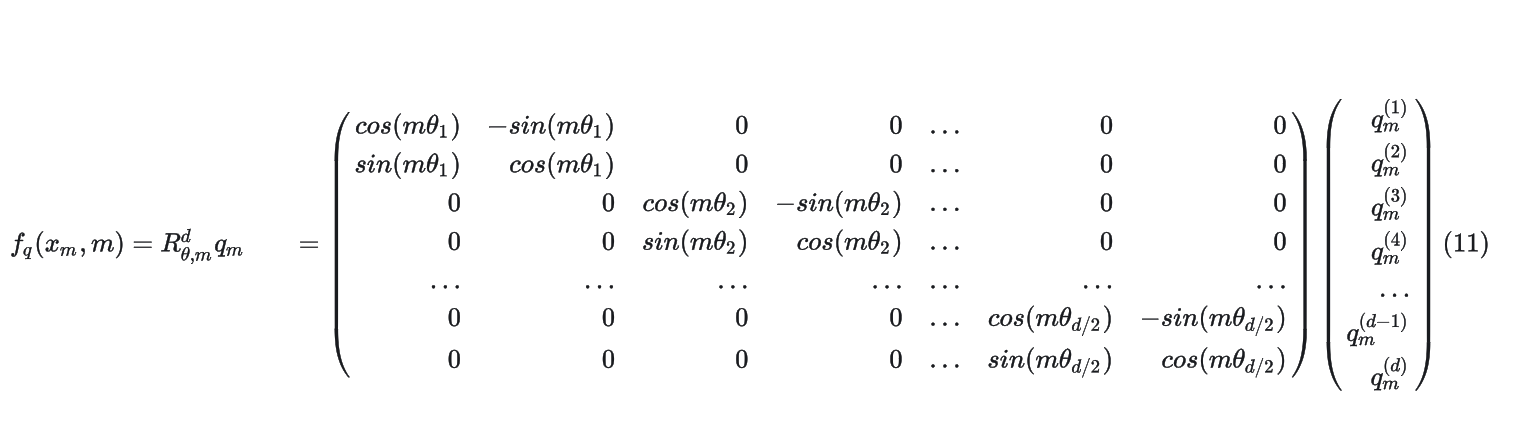

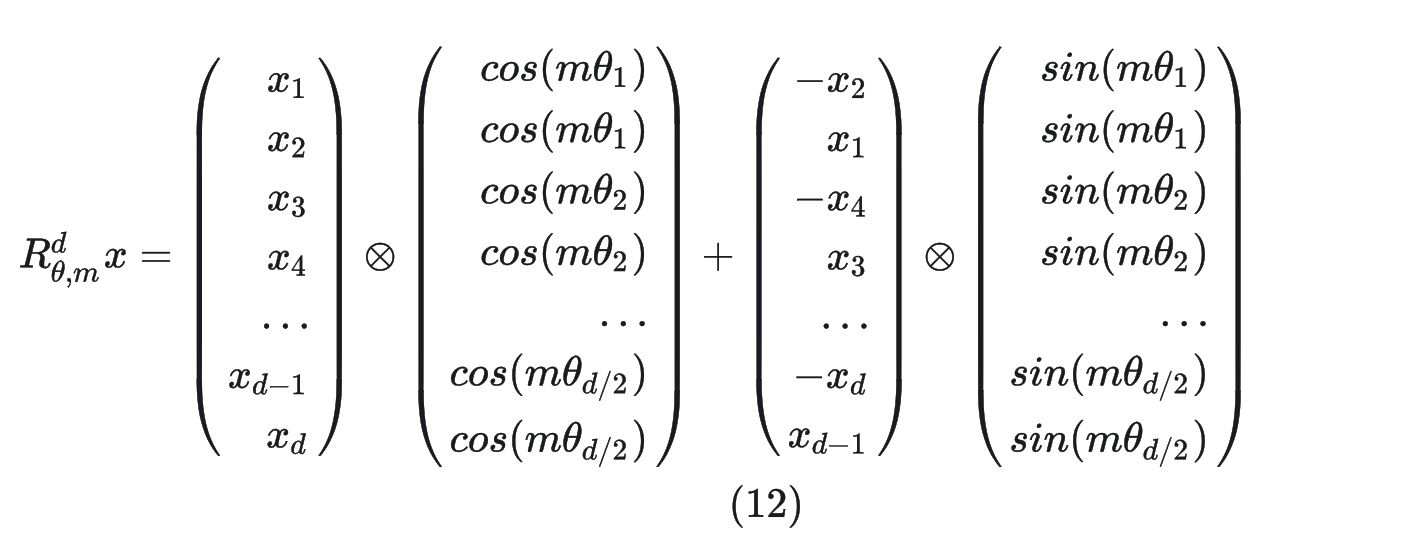

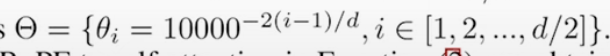

x1...xd are the embedding features

m is the position of the token

theta is the vector based on feature index

In [ ]:
def precompute_theta_pos_freq(head_dim: int,seq_len: int , device: str, theta: float = 100000.0 ):
  assert head_dim%2 == 0 , 'dim/2 ,check the head_dim'

  #Bulid theta param theta_i = 10000 ^ (-2(i-1)/head_dim) for i in (1,2,...,head_dim/2)
  #shape : (head_dim/2)
  theta_numerator = torch.argange(0,head_dim,2).float #2(i-1) for i in (1,2....head_dim/2),even
  #shape:(head_dim/2)
  theta = 1/theta**(theta_numerator/head_dim).to(device) #10000 ^ (-2(i-1)/head_dim) for i in (1,2,...,head_dim/2)

  #Build m
  #shape:(seq_len)
  m = torch.arange(0,seq_len)

  #Bulid m*theta
  #shape:(seq_len,head_dim/2)
  freqs = torch.outer(m,theta).float() # m[i]*theta[j]
  #shape:(seq_len,head_dim/2)
  freqs_complex = torch.polar(torch.ones_like(freqs),freqs) #（mag,angle）
  return freqs_complex


def apply_rotary_embeddings(x: torch.Tensor, freqs_complex: torch.Tensor, device: str):
    # Separate the last dimension pairs of two values, representing the real and imaginary parts of the complex number
    # Two consecutive values will become a single complex number
    # (B, Seq_Len, H, Head_Dim) -> (B, Seq_Len, H, Head_Dim/2)
    x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2)) # let last dim be 2
    # Reshape the freqs_complex tensor to match the shape of the x_complex tensor. So we need to add the batch dimension and the head dimension
    # (Seq_Len, Head_Dim/2) --> (1, Seq_Len, 1, Head_Dim/2)
    freqs_complex = freqs_complex.unsqueeze(0).unsqueeze(2)
    # Multiply each complex number in the x_complex tensor by the corresponding complex number in the freqs_complex tensor
    # Which results in the rotation of the complex number as shown in the Figure 1 of the paper
    # (B, Seq_Len, H, Head_Dim/2) * (1, Seq_Len, 1, Head_Dim/2) = (B, Seq_Len, H, Head_Dim/2)
    x_rotated = x_complex * freqs_complex
    # Convert the complex number back to the real number
    # (B, Seq_Len, H, Head_Dim/2) -> (B, Seq_Len, H, Head_Dim/2, 2)
    x_out = torch.view_as_real(x_rotated)
    # (B, Seq_Len, H, Head_Dim/2, 2) -> (B, Seq_Len, H, Head_Dim)
    x_out = x_out.reshape(*x.shape)
    return x_out.type_as(x).to(device)





